# Exploratory Analysis of the US Health Insurance Market from 2014-2016

This notebook does an exploratory analysis of the US Health Insurance Market from 2014-2016 provided as an sqlite database on Kaggle. The database is nearly 4 GB, so it was downloaded manually and placed in the folder 'data'.

In [1]:
# import relevant libraries

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy as sqla


## Connection to Database and Examination of Database Structure

In [2]:
# Connect to engine

metadata = sqla.MetaData()

engine =  sqla.create_engine("sqlite:///data/database.sqlite")

table_names = engine.table_names()

tables = dict()

for table in table_names:
    print(table+" Column Names:\n")
    tables[table] = sqla.Table(table, metadata, autoload=True, autoload_with=engine)
    print(tables[table].columns.keys())
    print("\n")

BenefitsCostSharing Column Names:

['BenefitName', 'BusinessYear', 'CoinsInnTier1', 'CoinsInnTier2', 'CoinsOutofNet', 'CopayInnTier1', 'CopayInnTier2', 'CopayOutofNet', 'EHBVarReason', 'Exclusions', 'Explanation', 'ImportDate', 'IsCovered', 'IsEHB', 'IsExclFromInnMOOP', 'IsExclFromOonMOOP', 'IsStateMandate', 'IsSubjToDedTier1', 'IsSubjToDedTier2', 'IssuerId', 'IssuerId2', 'LimitQty', 'LimitUnit', 'MinimumStay', 'PlanId', 'QuantLimitOnSvc', 'RowNumber', 'SourceName', 'StandardComponentId', 'StateCode', 'StateCode2', 'VersionNum']


BusinessRules Column Names:

['BusinessYear', 'StateCode', 'IssuerId', 'SourceName', 'VersionNum', 'ImportDate', 'IssuerId2', 'TIN', 'ProductId', 'StandardComponentId', 'EnrolleeContractRateDeterminationRule', 'TwoParentFamilyMaxDependentsRule', 'SingleParentFamilyMaxDependentsRule', 'DependentMaximumAgRule', 'ChildrenOnlyContractMaxChildrenRule', 'DomesticPartnerAsSpouseIndicator', 'SameSexPartnerAsSpouseIndicator', 'AgeDeterminationRule', 'MinimumTobaccoFre

This database contains 6 tables describing the insurance rates (Rate), insurance plan attributes (PlanAttributes), business rules (BusinessRules), Service area covered (ServiceArea), and cost sharing attributes of the insurance plan (BenefitsCostSharing). The remaining two tables provide continuity between years so that insurance plans can be joined across 2014, 2015, and 2016. (Crosswalk2015 and Crosswalk2016) Definitions of the fields in the database can be found [here](https://www.cms.gov/cciio/resources/data-resources/marketplace-puf.html). 

## Exploratory Analysis

The initial analysis focuses on the Rate table. There are several different insurance rates in this table depending on whether the insurance plan applies to an individual, a individual who smokes, a couple, an individual with dependents, or a couple with dependents. First, we construct a dataframe of the IndividualRates (regardless of state) for 2016 that are not zero, which indicates that the plan is some other type. Then, we calculate summary statistics of these rates. Finally, we make a histogram of individual rates.

C:\Users\aawie\AppData\Local\Continuum\Anaconda3\lib\site-packages\sqlalchemy\sql\sqltypes.py:596: SAWarning: Dialect sqlite+pysqlite does *not* support Decimal objects natively, and SQLAlchemy must convert from floating point - rounding errors and other issues may occur. Please consider storing Decimal numbers as strings or integers on this platform for lossless storage.
  'storage.' % (dialect.name, dialect.driver))


       IndividualRate
count    4.205826e+06
mean     3.387316e+02
std      5.367337e+02
min      0.000000e+00
25%      2.856000e+01
50%      2.975400e+02
75%      4.892200e+02
max      9.999000e+03


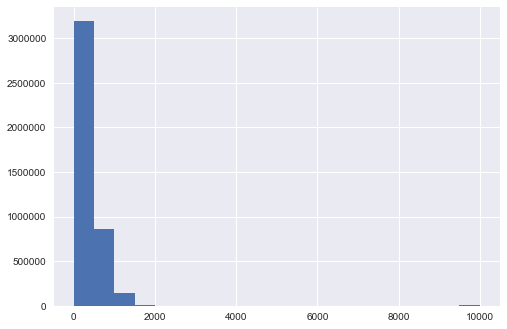

In [6]:

# Generate SQL statement

conn = engine.connect()

# Equivalent to SELECT IndividualRate FROM Rate
stmt = sqla.select([tables["Rate"].columns.IndividualRate])

# Adds where clause: SELECT IndividualRate FROM Rate WHERE BusinessYear = 2016
stmt = stmt.where(sqla.and_(tables["Rate"].columns.BusinessYear == 2016,
                            tables["Rate"].columns.Age != "Family Option"))

rates = pd.read_sql(stmt, conn)

print(rates.describe())
                  
plt.hist(rates['IndividualRate'], bins = 20)
plt.show()



Clearly, there is one extreme outlier where someone is paying nearly 10000 for a plan! To get a better sense of the rest of the data, we filter out this value and replot the histogram.

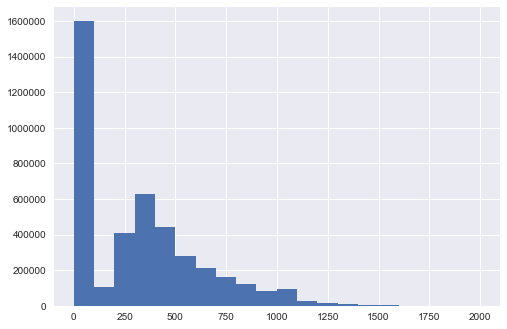

In [8]:
plt.hist(rates[rates['IndividualRate'] < 2000]['IndividualRate'], bins=20)
plt.show()